10X Genomics Data
- donor 1-4
- paired TCR and RNA


In [1]:
import os,sys
sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
import warnings
import scanpy as sc
import scirpy as ir
import anndata as ad
import pandas as pd
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt

/home/zl/anaconda3/envs/mvTCR/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import vqtcr as qt
path_base = '/mnt/d/Dataset/TCR/TCR-Donor1-4/'

/home/zl/anaconda3/envs/mvTCR/lib/python3.8/site-packages/numba/core/cpu.py:78: UserWarning: Numba extension module 'awkward.numba' failed to load due to 'ImportError(cannot import name 'NumbaTypeError' from 'numba.core.errors' (/home/zl/anaconda3/envs/mvTCR/lib/python3.8/site-packages/numba/core/errors.py))'.
  numba.core.entrypoints.init_all()


In [3]:
path_merged = path_base + 'merged_tcr_10X.h5ad'
path_filtered = path_base + 'filtered_tcr_10X.h5ad'
path_logged = path_base + 'logged+10X.h5ad'
path_hvg = path_base + 'hvg_5000.h5ad'
path_clean_split = path_base + 'v5_train_val_test.h5ad'
path_supervised = path_base + 'v6_supervised.h5ad'
path_avidity = path_base + 'v7_avidity.h5ad'

Data prepare

CD8+ T cells from donor. `merge rna and tcr`, `merge all donor`, `merge binding affinity`.

In [5]:
adatas = []
batch_names = []
for i in range(1,5):
    # RNA
    file_name = path_base + f'donor{i}/vdj_v1_hs_aggregated_donor{i}_filtered_feature_bc_matrix.h5'
    adata_tmp = sc.read_10x_h5(file_name)
    # TCR
    path_anno = path_base + f'donor{i}/vdj_v1_hs_aggregated_donor{i}_all_contig_annotations.csv'
    anno_tcr = ir.io.read_10x_vdj(path_anno)
    ir.pp.merge_with_ir(adata_tmp, anno_tcr)
    # print(adata_tmp)
    # print(adata_tcr)
    # barcode2idx = {barcode: i for i, barcode in enumerate(adata_tcr.obs_names)}
    # idx = [barcode2idx.get(barcode) for barcode in adata_tmp.obs_names]
    
    # adata_tmp.obsm["airr"] = adata_tcr.obsm["airr"][idx]
    # adata_tmp = adata_tmp[~ak.is_none(adata_tmp.obsm['airr']).to_numpy()]
    # Binding
    path_binding = path_base + f'donor{i}/vdj_v1_hs_aggregated_donor{i}_binarized_matrix.csv'
    binarized_matrix = pd.read_csv(path_binding, sep=',', header=0)
    
    for k in binarized_matrix.columns:
        adata_tmp.obs[k] = None
        adata_tmp.obs.loc[binarized_matrix['barcode'].values, k] = binarized_matrix[k].values
        adata_tmp.obs[k] = adata_tmp.obs[k].astype(str)
        
    adata_tmp.var_names_make_unique()
    adatas.append(adata_tmp)
    batch_names.append(f'donor{i}')

adata = adatas[0].concatenate(adatas[1:], batch_key='donor', batch_categories=batch_names)

for c in adata.obs.columns:
    if c.startswith('CD') or c.startswith('Ig') or c.startswith('HLA'):
        adata.obs[c] = adata.obs[c].astype(str)
sc.write(adata=adata, filename=path_merged)

/home/zl/anaconda3/envs/mvTCR/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [6]:
adata

AnnData object with n_obs × n_vars = 237883 × 33538
    obs: 'is_cell', 'high_confidence', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 'IR_VDJ_1_junction_aa', 'IR_VDJ_2_junction_aa', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_productive', 'IR_VJ_2_productive', 'IR_VDJ_1_productive', 'IR_VDJ_2_productive', 'IR_VJ_1_v_call', 'IR_VJ_2_v_call', 'IR_VDJ_1_v_call', 'IR_VDJ_2_v_call', 'has_ir', 'barcode', 'dono

In [7]:
# count_irs = sum([1 for x in adata.obsm['airr'] if x=='True'])
# print(f'Total Count: {len(adata.obs)}')
# print(f'With IR_Info: {count_irs}')

In [8]:
adata.obs['donor'].value_counts()

donor2    91921
donor1    55206
donor3    54137
donor4    36619
Name: donor, dtype: int64

QC

In [9]:
# adata = sc.read(path_merged)
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log10(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
mt_gene_index = np.where(mt_gene_mask)[0]
adata.obs['mt_fraction'] = adata.X[:, mt_gene_index].sum(1) / adata.X.sum(1)

/home/zl/anaconda3/envs/mvTCR/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:785: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/zl/anaconda3/envs/mvTCR/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:785: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


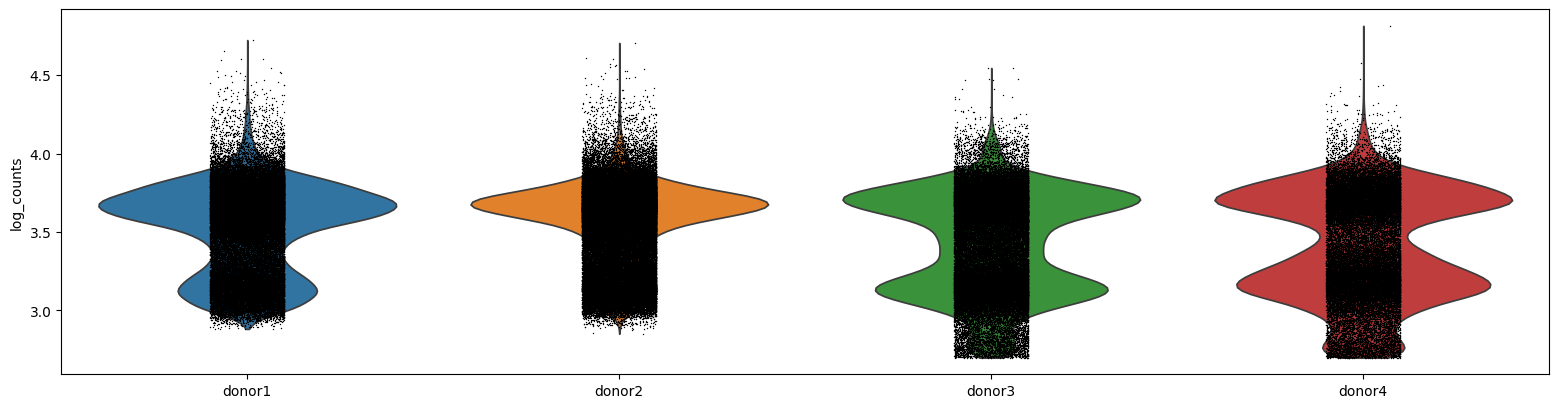

/home/zl/anaconda3/envs/mvTCR/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:785: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/zl/anaconda3/envs/mvTCR/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:785: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


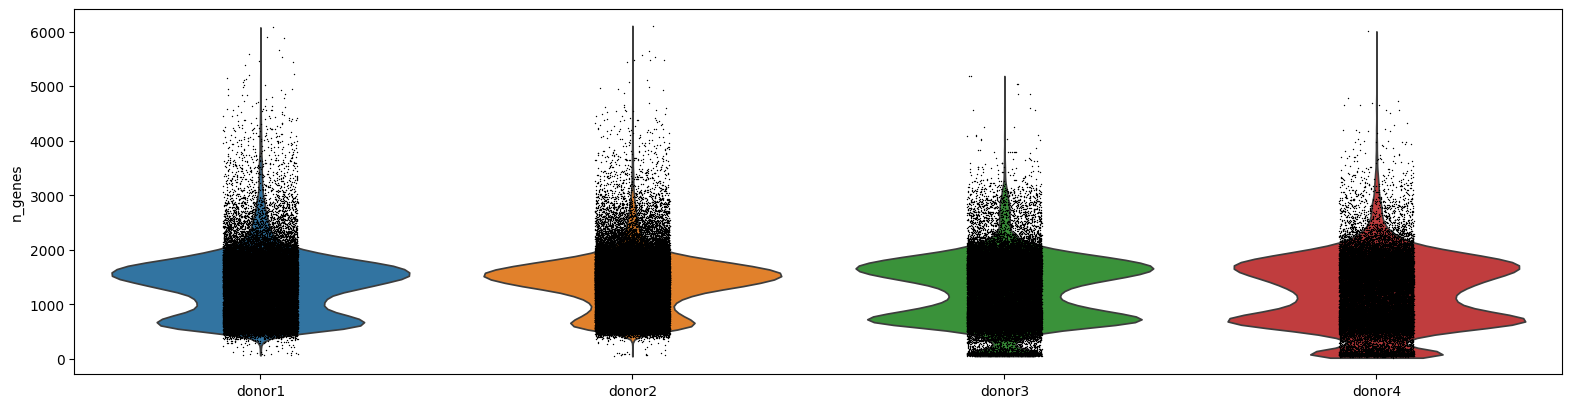

/home/zl/anaconda3/envs/mvTCR/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:785: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/zl/anaconda3/envs/mvTCR/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:785: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


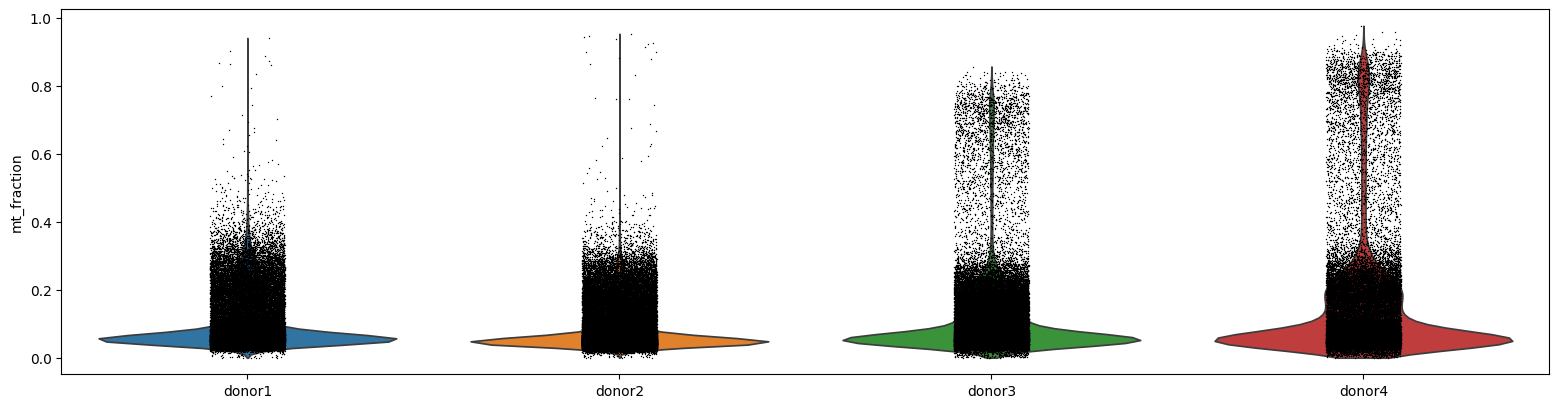

In [10]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (15, 5)
sc.pl.violin(adata, ['log_counts'], groupby='donor', size=1, log=False, rotation=0)
sc.pl.violin(adata, ['n_genes'], groupby='donor', size=1, log=False, rotation=0)
sc.pl.violin(adata, ['mt_fraction'], groupby='donor', size=1, log=False, rotation=0)

<Axes: title={'center': 'mt fraction'}, xlabel='n_counts', ylabel='n_genes'>

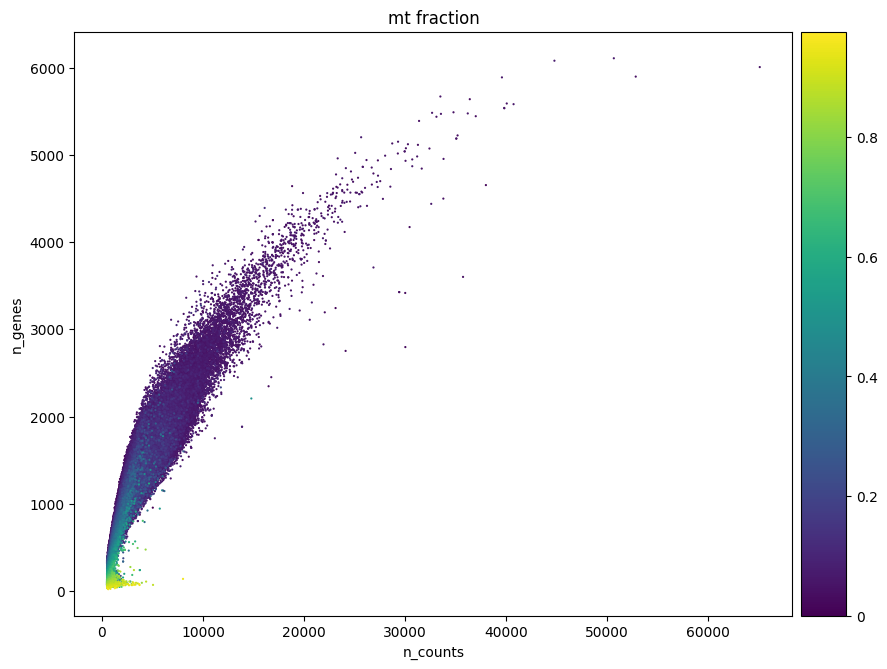

In [11]:
rcParams['figure.figsize'] = (8, 8)
sc.pl.scatter(adata, y='n_genes', x='n_counts', color='mt_fraction', size=10, show=False)

<Axes: title={'center': 'donor'}, xlabel='n_counts', ylabel='n_genes'>

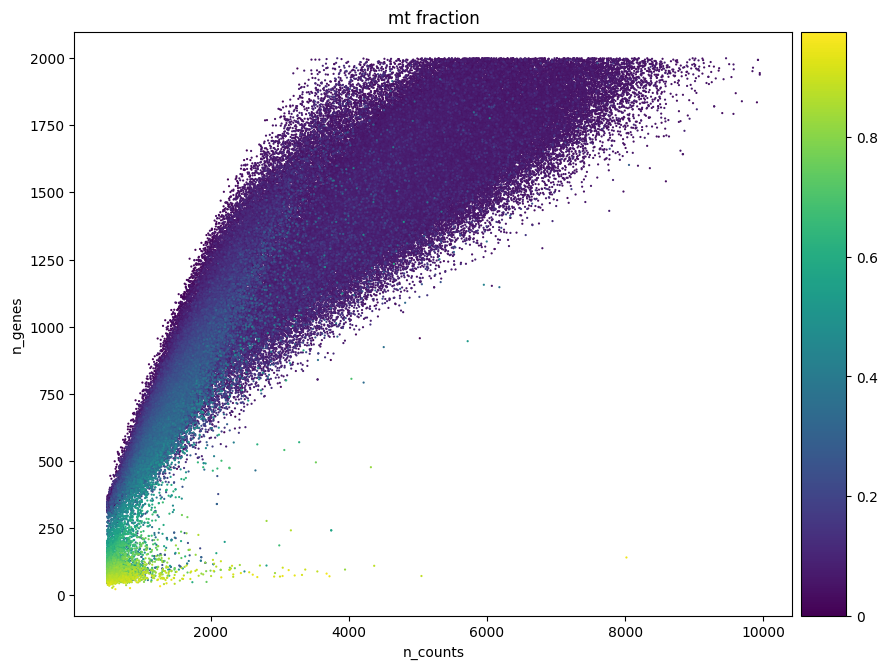

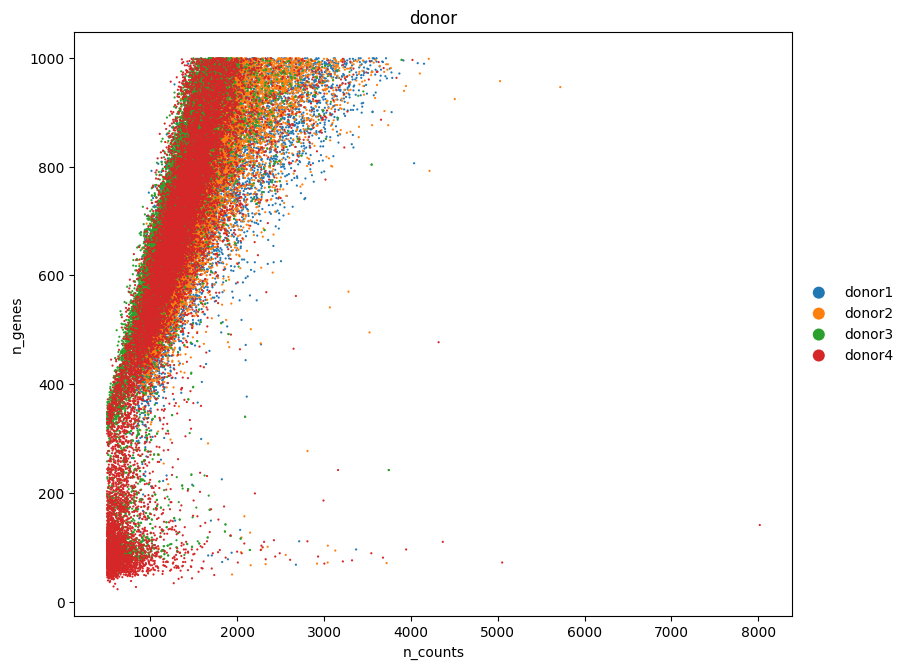

In [12]:
sc.pl.scatter(adata[np.logical_and(adata.obs['n_genes']<2000, adata.obs['n_counts']<10000)],
             y='n_genes', x='n_counts', color='mt_fraction', size=10, show=False)
sc.pl.scatter(adata[np.logical_and(adata.obs['n_genes']<1000, adata.obs['n_counts']<10000)],
             y='n_genes', x='n_counts', color='donor', size=10, show=False)

Cell filtering

In [13]:
adata_tmp = adata.copy()
print(f'Total number of cells: {adata_tmp.n_obs}')
high_mt = adata_tmp.obs['mt_fraction'] < 0.2
adata_tmp = adata_tmp[high_mt]
print(f'Number of cells after MT filter: {adata_tmp.n_obs}')

Total number of cells: 237883
Number of cells after MT filter: 208593


In [14]:
low_count = adata_tmp.obs['n_counts'] > 1000    # Scanpy 自带函数
adata_tmp = adata_tmp[low_count]
print(f'Number of cells after minimum count filter: {adata_tmp.n_obs}')
sc.pp.filter_cells(adata_tmp, max_counts=10000)
print(f'Number of cells after maximun filter: {adata_tmp.n_obs}')

Number of cells after minimum count filter: 204696


/home/zl/anaconda3/envs/mvTCR/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:128: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  if min_genes is None and max_genes is None: adata.obs['n_counts'] = number


Number of cells after maximun filter: 201428


In [15]:
low_genes = adata_tmp.obs['n_genes'] > 500
adata_tmp = adata_tmp[low_genes]
print(f'Number of cells after minimum gene filter: {adata_tmp.n_obs}')

Number of cells after minimum gene filter: 201235


Gene filtering

In [16]:
sc.pp.filter_genes(adata_tmp, min_cells=10)
print(f'Number of cells after gene filter: {adata_tmp.n_vars}')

/home/zl/anaconda3/envs/mvTCR/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:224: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


Number of cells after gene filter: 19707


Doublet detection, evaluated by Scrublet

In [17]:
import scrublet as scr
import scipy.io
import time

In [18]:
adata_tmp.obs['doublet_score'] = np.zeros(adata_tmp.shape[0])
adata_tmp.obs['doublet'] = np.zeros(adata_tmp.shape[0])

In [19]:
min_counts = 2
min_cells = 3
vscore_percentile = 85
n_pc = 50

expected_doublet_rate = 0.02
sim_doublet_ratio = 3
n_neighbors = 15

for batch in enumerate(adata_tmp.obs['donor'].cat.categories):
    print(batch)
    t0 = time.time()
    idx = np.flatnonzero(adata_tmp.obs['donor']==batch[1])
    scrub = scr.Scrublet(counts_matrix=adata_tmp[idx, :].X, 
                         n_neighbors=n_neighbors,
                         sim_doublet_ratio=sim_doublet_ratio,
                         expected_doublet_rate=expected_doublet_rate)
    doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=min_counts,
                                                              min_cells=min_cells,
                                                              n_prin_comps=n_pc,
                                                              use_approx_neighbors=True,
                                                              get_doublet_neighbor_parents=False)
    adata_tmp.obs['doublet_score'].iloc[idx] = doublet_scores
    adata_tmp.obs['doublet'].iloc[idx] = predicted_doublets
    t1 = time.time()
    print('Elapsed time: {:.1f} seconds'.format(t1-t0))

(0, 'donor1')
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.14
Detected doublet rate = 1.7%
Estimated detectable doublet fraction = 45.0%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 3.8%
Elapsed time: 46.3 seconds
Elapsed time: 47.6 seconds
(1, 'donor2')


/home/zl/anaconda3/envs/mvTCR/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.14
Detected doublet rate = 2.1%
Estimated detectable doublet fraction = 34.8%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 6.1%
Elapsed time: 77.9 seconds
Elapsed time: 80.1 seconds
(2, 'donor3')


/home/zl/anaconda3/envs/mvTCR/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.15
Detected doublet rate = 1.7%
Estimated detectable doublet fraction = 42.7%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 4.0%
Elapsed time: 46.5 seconds
Elapsed time: 47.6 seconds
(3, 'donor4')


/home/zl/anaconda3/envs/mvTCR/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.14
Detected doublet rate = 1.7%
Estimated detectable doublet fraction = 45.6%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 3.7%
Elapsed time: 29.3 seconds
Elapsed time: 29.9 seconds


/home/zl/anaconda3/envs/mvTCR/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


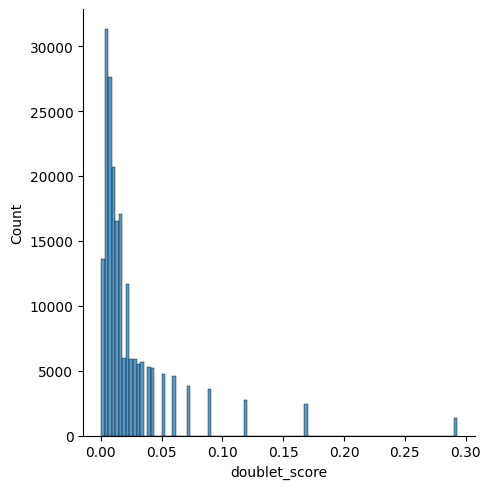

In [20]:
rcParams['figure.figsize'] = (6, 6)
import seaborn as sb
sb.displot(adata_tmp.obs['doublet_score'], bins=100, kde=False)

/home/zl/anaconda3/envs/mvTCR/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:785: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/zl/anaconda3/envs/mvTCR/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:785: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


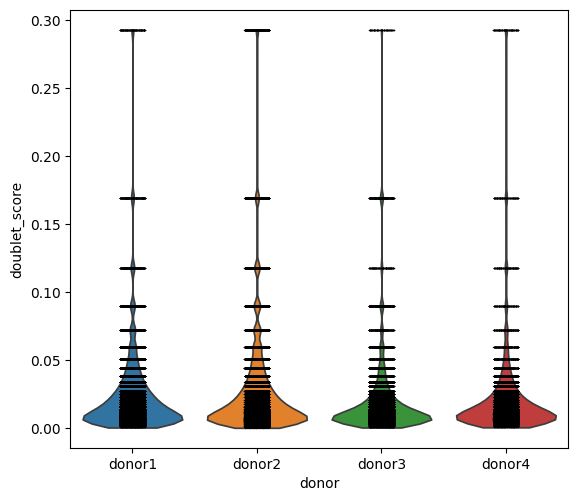

In [21]:
sc.pl.violin(adata_tmp, ['doublet_score'], groupby='donor', size=1, log=False)

In [22]:
thr = 0.05
idx_filter = adata_tmp.obs['doublet_score'] <= thr
adata_tmp =  adata_tmp[idx_filter].copy()
print(f'Number of cells after doublet filter: {adata_tmp.n_obs}')   # not cpnsistence with mvTCR

Number of cells after doublet filter: 178033


QC after filtering

/home/zl/anaconda3/envs/mvTCR/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:785: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/zl/anaconda3/envs/mvTCR/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:785: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


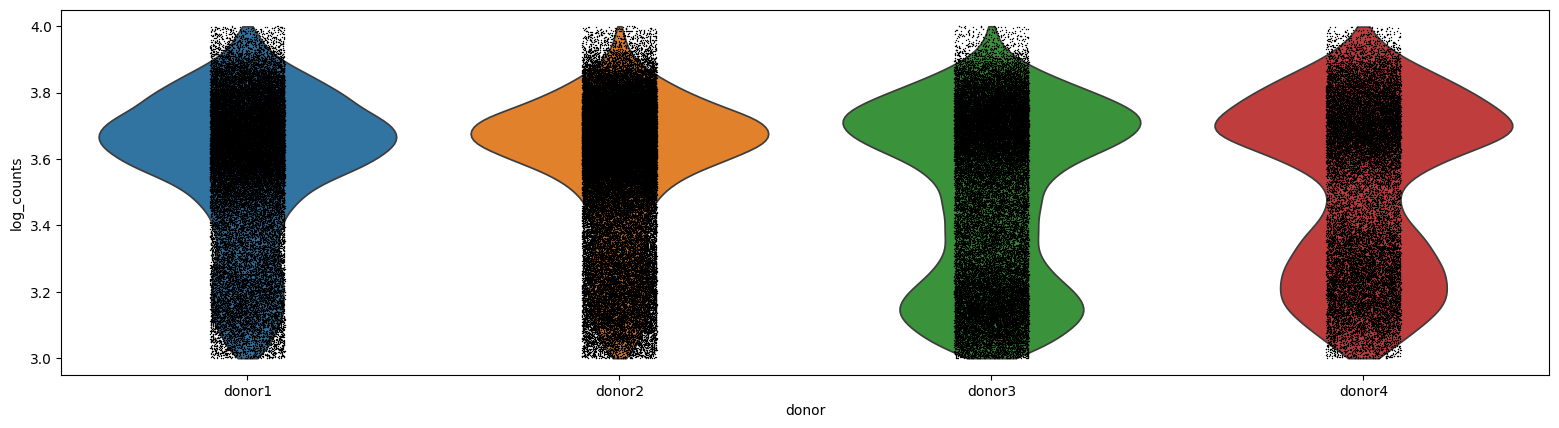

/home/zl/anaconda3/envs/mvTCR/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:785: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/zl/anaconda3/envs/mvTCR/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:785: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


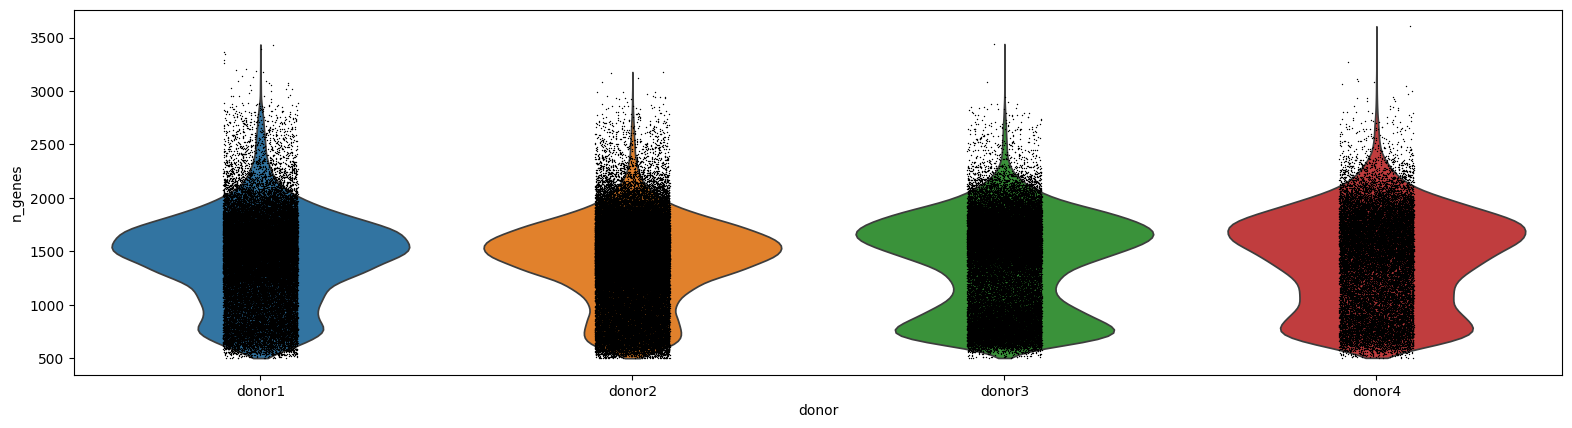

/home/zl/anaconda3/envs/mvTCR/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:785: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/zl/anaconda3/envs/mvTCR/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:785: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


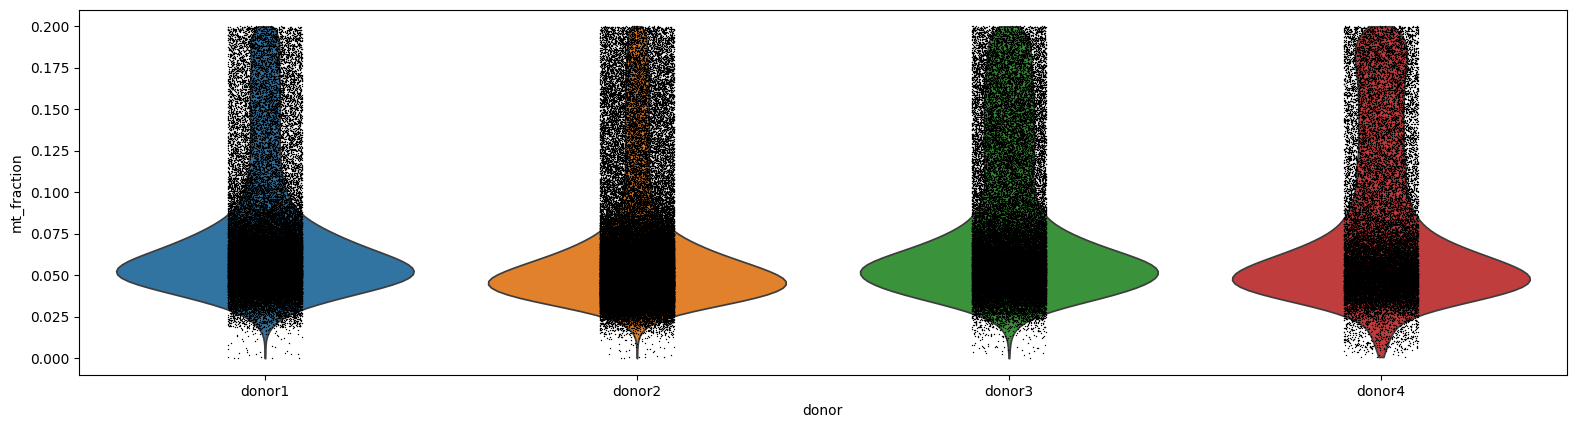

In [23]:
rcParams['figure.figsize'] = (15, 5)
sc.pl.violin(adata_tmp, ['log_counts'], groupby='donor', size=1, log=False)
sc.pl.violin(adata_tmp, ['n_genes'], groupby='donor', size=1, log=False)
sc.pl.violin(adata_tmp, ['mt_fraction'], groupby='donor', size=1, log=False)

In [24]:
df = adata_tmp.obs[['n_genes', 'n_counts', 'donor']]
df_all = pd.DataFrame(df.groupby(by='donor')['n_genes'].apply(np.mean).values,
                      index=df.groupby(by='donor')['n_genes'].apply(np.mean).index,
                      columns=['mean_genes'])
df_all['median_genes'] = df.groupby(by='donor')['n_genes'].apply(np.median).values
df_all['mean_counts'] = df.groupby(by='donor')['n_counts'].apply(np.mean).values
df_all['median_counts'] = df.groupby(by='donor')['n_counts'].apply(np.median).values
df_all

mean_genes  median_genes  mean_counts  median_counts
donor                                                        
donor1  1428.021126        1472.0  4242.394531         4263.0
donor2  1409.295802        1462.0  4177.520020         4335.0
donor3  1383.914059        1483.0  3713.665039         3770.0
donor4  1412.810308        1475.0  3918.452393         4044.0

In [25]:
adata_tmp.obs['doublet'] = adata_tmp.obs['doublet'].astype(str)

In [26]:
sc.write(adata=adata_tmp, filename=path_filtered)

Normalization

In [27]:
# adata_tmp = sc.read(path_filtered)

In [28]:
sc.pp.normalize_total(adata_tmp, target_sum=1e4)
sc.pp.log1p(adata_tmp)

In [29]:
sc.write(adata=adata_tmp, filename=path_logged)

HVGs

In [ ]:
# adata_tmp = sc.read(path_logged)

In [30]:
adata_tmp.uns['log1p'] = {'base': None}
sc.pp.highly_variable_genes(adata_tmp, n_top_genes=5000, batch_key='donor')
print(f'Shape before: {adata_tmp.shape}')
adata_tmp = adata_tmp[:, adata_tmp.var['highly_variable']]
print(f'Shape after: {adata_tmp.shape}')

/home/zl/anaconda3/envs/mvTCR/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Shape before: (178033, 19707)
Shape after: (178033, 5000)


In [31]:
sc.write(adata=adata_tmp, filename=path_hvg)

**Model Specific Preproccessing**

Clean cells without or multipel IR information. 
Filter out chains without paired TRA and TRB.

In [32]:
adata = sc.read_h5ad(path_hvg)

In [33]:
adata.obs

is_cell high_confidence multi_chain  \
AAACGGGAGAAGATTC-1-donor1    True            True       False   
AAACGGGTCGGACAAG-1-donor1    True            True       False   
AAAGATGGTACAGACG-1-donor1    True            True       False   
AAAGTAGAGACGCTTT-1-donor1    True            True       False   
AAAGTAGAGCGCTTAT-1-donor1    True            True       False   
...                           ...             ...         ...   
TTTGTCACATCAGTAC-8-donor4    True            True       False   
TTTGTCAGTCTAAACC-8-donor4    True            True       False   
TTTGTCAGTCTCTCGT-8-donor4    True            True       False   
TTTGTCATCCCACTTG-8-donor4    True            True       False   
TTTGTCATCTCTAAGG-8-donor4    True            True       False   

                                                                extra_chains  \
AAACGGGAGAAGATTC-1-donor1  [{"c_call": "TRBC2", "consensus_count": 3996, ...   
AAACGGGTCGGACAAG-1-donor1                                                 []   
AAAGATGGTACAGACG-1-donor1  [{"c_call": "TRAC", "consensus_count": 18416, ...   
AAAGTAGAGACGCTTT-1-donor1                                                 []   
AAAGTAGAGCGCTTAT-1-donor1                                                 []   
...                                                                      ...   
TTTGTCACATCAGTAC-8-donor4  [{"c_call": "TRBC2", "consensus_count": 2888, ...   
TTTGTCAGTCTAAACC-8-donor4                                                 []   
TTTGTCAGTCTCTCGT-8-donor4                                                 []   
TTTGTCATCCCACTTG-8-donor4                                                 []   
TTTGTCATCTCTAAGG-8-donor4                                                 []   

                          IR_VJ_1_c_call IR_VJ_2_c_call IR_VDJ_1_c_call  \
AAACGGGAGAAGATTC-1-donor1           TRAC            NaN           TRBC1   
AAACGGGTCGGACAAG-1-donor1           TRAC            NaN           TRBC2   
AAAGATGGTACAGACG-1-donor1           TRAC            NaN           TRBC2   
AAAGTAGAGACGCTTT-1-donor1           TRAC            NaN           TRBC2   
AAAGTAGAGCGCTTAT-1-donor1           TRAC           TRAC           TRBC2   
...                                  ...            ...             ...   
TTTGTCACATCAGTAC-8-donor4           TRAC            NaN           TRBC2   
TTTGTCAGTCTAAACC-8-donor4           TRAC            NaN           TRBC2   
TTTGTCAGTCTCTCGT-8-donor4           TRAC            NaN           TRBC2   
TTTGTCATCCCACTTG-8-donor4           TRAC            NaN           TRBC2   
TTTGTCATCTCTAAGG-8-donor4           TRAC            NaN           TRBC2   

                          IR_VDJ_2_c_call  IR_VJ_1_consensus_count  \
AAACGGGAGAAGATTC-1-donor1             NaN                  36437.0   
AAACGGGTCGGACAAG-1-donor1             NaN                  18565.0   
AAAGATGGTACAGACG-1-donor1             NaN                  31549.0   
AAAGTAGAGACGCTTT-1-donor1             NaN                  34680.0   
AAAGTAGAGCGCTTAT-1-donor1             NaN                  30686.0   
...                                   ...                      ...   
TTTGTCACATCAGTAC-8-donor4             NaN                   2856.0   
TTTGTCAGTCTAAACC-8-donor4             NaN                   5895.0   
TTTGTCAGTCTCTCGT-8-donor4             NaN                   4090.0   
TTTGTCATCCCACTTG-8-donor4             NaN                   8036.0   
TTTGTCATCTCTAAGG-8-donor4             NaN                   2435.0   

                           IR_VJ_2_consensus_count  ...  \
AAACGGGAGAAGATTC-1-donor1                      NaN  ...   
AAACGGGTCGGACAAG-1-donor1                      NaN  ...   
AAAGATGGTACAGACG-1-donor1                      NaN  ...   
AAAGTAGAGACGCTTT-1-donor1                      NaN  ...   
AAAGTAGAGCGCTTAT-1-donor1                  23335.0  ...   
...                                            ...  ...   
TTTGTCACATCAGTAC-8-donor4                      NaN  ...   
TTTGTCAGTCTAAACC-8-donor4                      NaN  ...   
TTTGTCAGTCT

In [34]:
print('All cells: ', adata.shape)
adata = adata[adata.obs['has_ir'] == 'True']
print('With IRs: ', adata.shape)
adata = adata[adata.obs['multi_chain'] == 'False']
print('With 1 IR set: ', adata.shape)
adata = adata[(adata.obs['IR_VJ_1_junction_aa'] != 'None') & (~adata.obs['IR_VJ_1_junction_aa'].isna()) & 
              (adata.obs['IR_VDJ_1_junction_aa'] != 'None') & (~adata.obs['IR_VDJ_1_junction_aa'].isna())]
print('With full IR:', adata.shape)

All cells:  (178033, 5000)
With IRs:  (151830, 5000)
With 1 IR set:  (151674, 5000)
With full IR: (128296, 5000)


Clonetype annotation

The clonotype annotation from 10x defines clonotypes not accross all donors. Therefor, public TCRs might leak between training and testing data. Further, cells with the same TCR but multiple IRs are classified as different clonotypes. We therefor assign own clonotype labels based on complete correspondence based on alpha and beta chain.

In [35]:
adata.obs['TRA+TRB'] = adata.obs['IR_VJ_1_junction_aa'].astype(str) + '+' + adata.obs['IR_VDJ_1_junction_aa'].astype(str)
clono_dict = {clone: idx for idx, clone in enumerate(adata.obs['TRA+TRB'].unique())}
adata.obs['clonotype'] = adata.obs['TRA+TRB'].map(clono_dict)
print(len(adata.obs['clonotype'].unique()))
adata.obs['clonotype'].head()

51067


/tmp/ipykernel_2416123/3814546318.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['TRA+TRB'] = adata.obs['IR_VJ_1_junction_aa'].astype(str) + '+' + adata.obs['IR_VDJ_1_junction_aa'].astype(str)


AAACGGGAGAAGATTC-1-donor1    0
AAACGGGTCGGACAAG-1-donor1    1
AAAGATGGTACAGACG-1-donor1    2
AAAGTAGAGACGCTTT-1-donor1    3
AAAGTAGAGCGCTTAT-1-donor1    4
Name: clonotype, dtype: int64

embed aa

Append both chains, add start ('<'), stop ('>') and seperator ('+') token. For training purpose IR data might be needed as one hot vector.

In [38]:
import sys
sys.path.append('../mvTCR')
import tcr_embedding.utils_preprocessing as utils

In [39]:
adata.obs['TRA+TRB'] = adata.obs['IR_VJ_1_junction_aa'].astype(str) + '+' + adata.obs['IR_VDJ_1_junction_aa'].astype(str)
pad = adata.obs['TRA+TRB'].str.len().max()
pad = int(pad)
pad

45

In [40]:
aa_to_id = {'_': 0, 'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13,
            'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20, '+': 21, '<': 22, '>': 23}
utils.aa_encoding(adata, read_col='TRA+TRB', ohe_col='one_hot', label_col='tcr_seq', length_col='seq_len', pad=pad, aa_to_id=aa_to_id, start_end_symbol=True)

In [41]:
print(adata.obsm['tcr_seq'].shape)
print(adata.obsm['one_hot'].shape)
print(adata.uns['aa_to_id'])

(128296, 47)
(128296, 47, 24)
{'_': 0, 'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20, '+': 21, '<': 22, '>': 23}


antigen binding encoding 

Process the Binding Specificity to form that it easy to use during training.

In [42]:
antigen_binding_list = [x for x in adata.obs.columns if x.endswith('_binder')]
binding_matrix = (adata.obs[antigen_binding_list] == 'True').values.astype(int)
binding_matrix.shape

(128296, 50)

In [43]:
unique_value, count = np.unique(binding_matrix.sum(axis=1), return_counts=True)
for unique_value_, count_ in zip(unique_value, count):
    print(f'Cells with {unique_value_} bindings: {count_}')

Cells with 0 bindings: 66661
Cells with 1 bindings: 61635


In [44]:
label_to_binding = {label_id: antigen for label_id, antigen in enumerate(antigen_binding_list)}
label_to_binding[-1] = 'no_data'  # For cells without binding data
binding_to_label = {antigen: label_id for label_id, antigen in enumerate(antigen_binding_list)}
binding_to_label['no_data'] = -1
binding_to_label == {v: k for k, v in label_to_binding.items()}  # sanity check, if both dicts are the reverse of each other

True

In [45]:
adata.obs['has_binding'] = binding_matrix.sum(axis=1).astype(bool)
adata.obs['has_binding'].head()

AAACGGGAGAAGATTC-1-donor1     True
AAACGGGTCGGACAAG-1-donor1    False
AAAGATGGTACAGACG-1-donor1    False
AAAGTAGAGACGCTTT-1-donor1    False
AAAGTAGAGCGCTTAT-1-donor1    False
Name: has_binding, dtype: bool

In [46]:
adata.obs['binding_label'] = np.argmax(binding_matrix, axis=1)
adata.obs['binding_label'][~adata.obs['has_binding']] = -1
adata.obs['binding_label'].head()

AAACGGGAGAAGATTC-1-donor1    29
AAACGGGTCGGACAAG-1-donor1    -1
AAAGATGGTACAGACG-1-donor1    -1
AAAGTAGAGACGCTTT-1-donor1    -1
AAAGTAGAGCGCTTAT-1-donor1    -1
Name: binding_label, dtype: int64

In [47]:
adata.obs['binding_name'] = adata.obs['binding_label'].map(label_to_binding)
adata.obs['binding_name'].head()

AAACGGGAGAAGATTC-1-donor1    A0301_KLGGALQAK_IE-1_CMV_binder
AAACGGGTCGGACAAG-1-donor1                            no_data
AAAGATGGTACAGACG-1-donor1                            no_data
AAAGTAGAGACGCTTT-1-donor1                            no_data
AAAGTAGAGCGCTTAT-1-donor1                            no_data
Name: binding_name, dtype: object

Train val split

We don't want to include the same clonotype in the different splits. Further we want to have the same data distribution in donor and antigen binding dimension to have faithful results.

Therefore we need stratification (similar label distribution across the sets) and grouped sampling (groups, i.e. the same clonotype is only present in one set)

In [48]:
adata.obs['donor+binding'] = adata.obs['donor'].astype(str) + '_' + adata.obs['binding_name'].astype(str)
adata.obs['donor+binding'].sample(10)

GCAATCACAAGCCGTC-3-donor2                             donor2_no_data
GAAATGAAGATGCGAC-34-donor2    donor2_B0801_RAKFKQLL_BZLF1_EBV_binder
TTTACTGCAAAGCGGT-16-donor1                            donor1_no_data
TAGTTGGTCACTCTTA-6-donor3     donor3_A0301_KLGGALQAK_IE-1_CMV_binder
CTGTTTACATGGATGG-40-donor2                            donor2_no_data
TTTCCTCCATTGTGCA-40-donor2                            donor2_no_data
AGGCCACAGTTGAGTA-2-donor4                             donor4_no_data
GAAACTCAGTAACCCT-20-donor1                            donor1_no_data
AGCTCCTTCTGTCTCG-5-donor3     donor3_A0301_KLGGALQAK_IE-1_CMV_binder
ATAAGAGAGTGCGATG-6-donor3     donor3_A0301_KLGGALQAK_IE-1_CMV_binder
Name: donor+binding, dtype: object

In [49]:
random_seed = 15
# Create Train-Val and Test set
train_val, test = utils.stratified_group_shuffle_split(adata.obs, stratify_col='donor+binding', group_col='clonotype', val_split=0.20, random_seed=random_seed)
# Split Train-Val into Train and Val set
train, val = utils.stratified_group_shuffle_split(train_val, stratify_col='donor+binding', group_col='clonotype', val_split=0.25, random_seed=random_seed)

100%|██████████| 111/111 [00:01<00:00, 60.22it/s]


In [50]:
print('Train Samples: ', len(train))
print('Train Ratio: ', len(train) / len(adata.obs))
print('Val Samples: ', len(val))
print('Val Ratio: ', len(val) / len(adata.obs))
print('Test Samples: ', len(test))
print('Test Ratio: ', len(test) / len(adata.obs))

Train Samples:  90960
Train Ratio:  0.7089854710980856
Val Samples:  18133
Val Ratio:  0.1413372201783376
Test Samples:  19203
Test Ratio:  0.14967730872357674


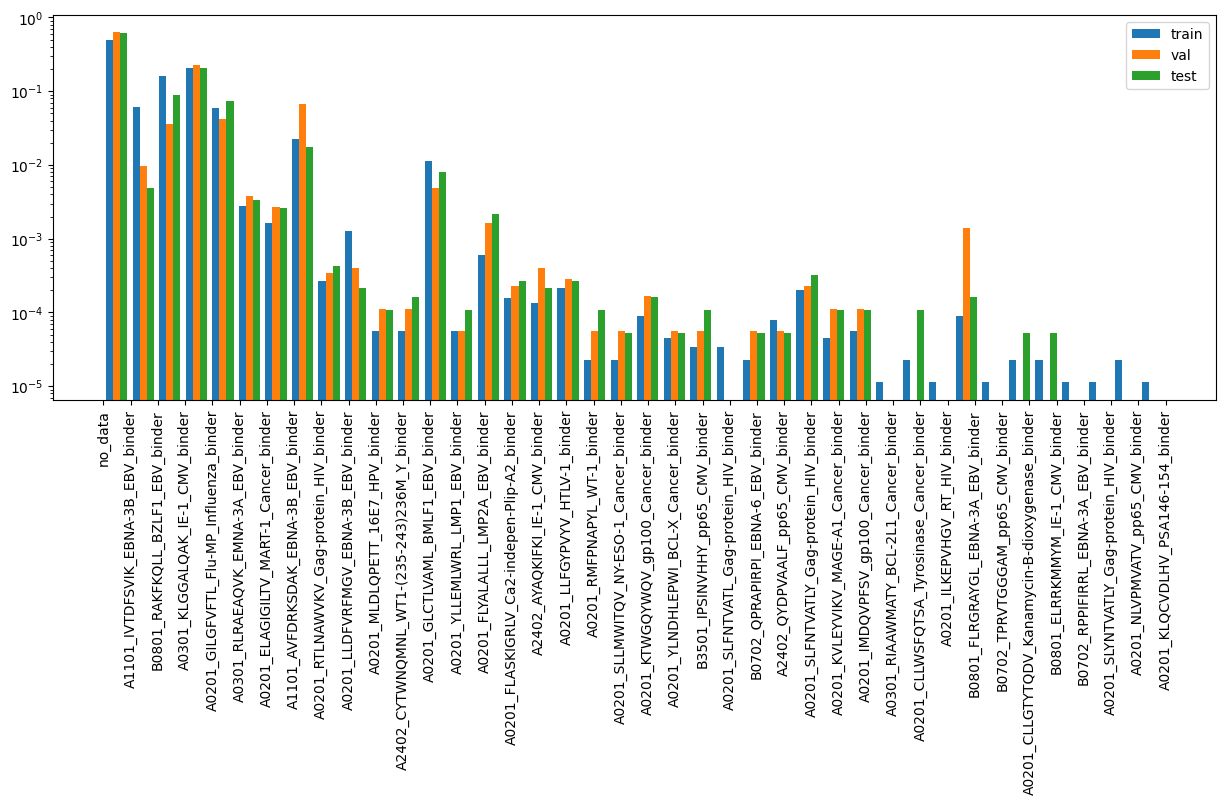

In [52]:
import matplotlib.pyplot as pl
pl.figure(figsize=(15,5))
pl.hist([train['binding_name'], val['binding_name'], test['binding_name']], density=True, bins=len(train['binding_name'].unique()), label=['train', 'val', 'test'])
pl.yscale('log')
pl.xticks(rotation='vertical')
pl.legend(loc='upper right')
pl.show()

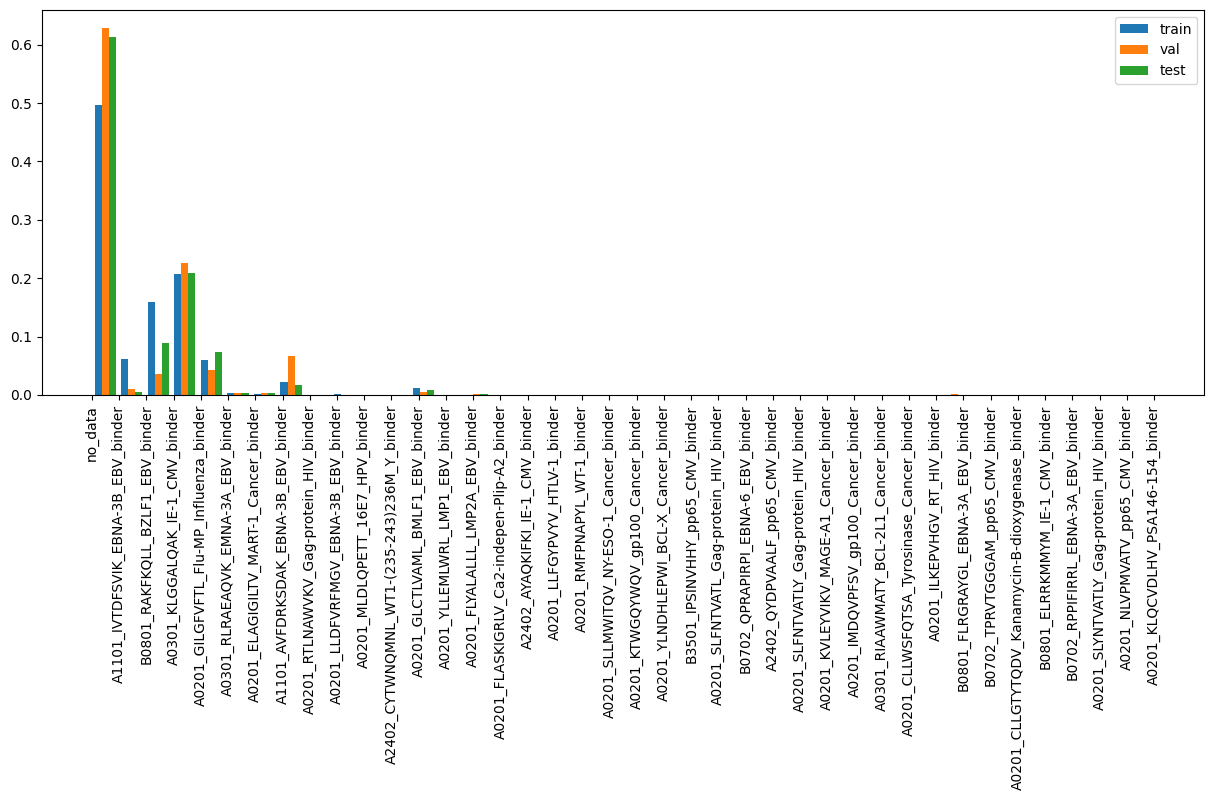

In [53]:
pl.figure(figsize=(15,5))
pl.hist([train['binding_name'], val['binding_name'], test['binding_name']], density=True, bins=len(train['binding_name'].unique()), label=['train', 'val', 'test'])
pl.xticks(rotation='vertical')
pl.legend(loc='upper right')
pl.show()

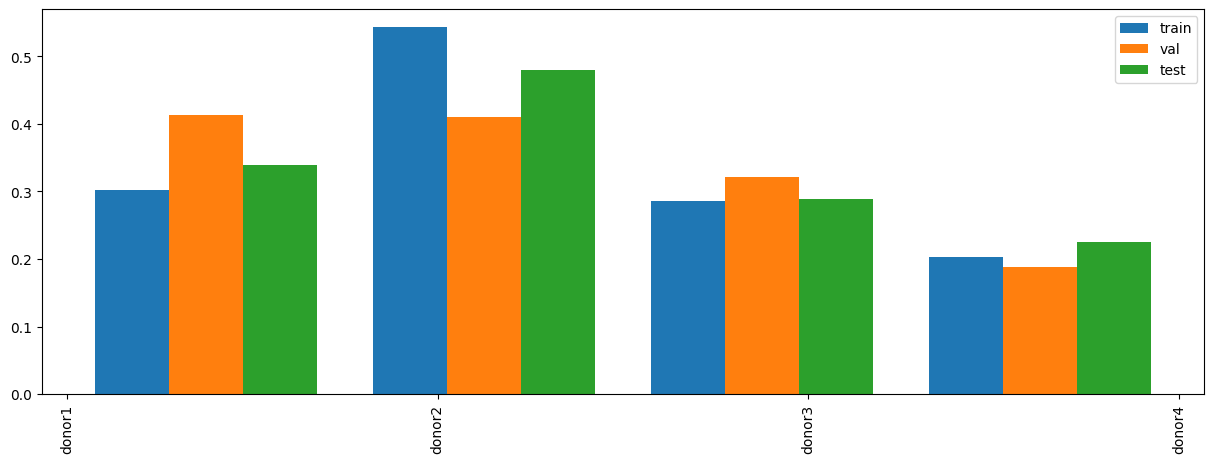

In [54]:
pl.figure(figsize=(15,5))
pl.hist([train['donor'], val['donor'], test['donor']], density=True, bins=len(train['donor'].unique()), label=['train', 'val', 'test'])
pl.xticks(rotation='vertical')
pl.legend(loc='upper right')
pl.show()

Check if clonotypes are unique within each set

In [55]:
form_train = set(train['clonotype'].tolist())
form_val = set(val['clonotype'].tolist())
form_test = set(test['clonotype'].tolist())

print('Intersection in clonotypes between two sets should be empty\n')
print('Intersection in clonotypes between train and test: ', form_train.intersection(form_test))
print('Intersection in clonotypes between train and val: ', form_train.intersection(form_val))
print('Intersection in clonotypes between val and test: ', form_val.intersection(form_test))
# print('\nSanity Check - Intersection in clonotypes between train and train: ', form_train.intersection(form_train))

Intersection in clonotypes between two sets should be empty

Intersection in clonotypes between train and test:  set()
Intersection in clonotypes between train and val:  set()
Intersection in clonotypes between val and test:  set()


In [56]:
adata.obs.loc[train.index, 'set'] = 'train'
adata.obs.loc[val.index, 'set'] = 'val'
adata.obs.loc[test.index, 'set'] = 'test'
adata.obs['set'].value_counts()

train    90960
test     19203
val      18133
Name: set, dtype: int64

In [57]:
adata.obs['set'].sample(20)

CCTAGCTCATCTACGA-12-donor1     test
GTCAAGTGTACCGAGA-39-donor1     test
TCTCTAAGTTGTGGCC-28-donor2    train
CCTCAGTGTGCGAAAC-39-donor2      val
GAACGGACAAAGGTGC-7-donor4     train
AAATGCCAGACACGAC-2-donor4     train
ATCTACTAGATGTGGC-14-donor2    train
TACTTGTTCCGCAGTG-4-donor1       val
AAACCTGGTTAGATGA-4-donor2       val
GCACTCTAGTCATGCT-33-donor1      val
GGGCATCTCAGAGCTT-8-donor4     train
GCACATATCACTTACT-23-donor2    train
GATCGTACACTTGGAT-3-donor4     train
ATCACGACATCCGGGT-18-donor1    train
TGAGGGAAGGCCATAG-2-donor3     train
GCTGGGTAGTGTACGG-16-donor1    train
AACTCTTAGAGCCTAG-40-donor2    train
GACTAACTCGGTGTCG-29-donor1    train
CTGCCTAAGCTAACAA-3-donor3     train
GAATGAATCGGAAACG-23-donor2     test
Name: set, dtype: object

In [58]:
adata.write_h5ad(path_clean_split, compression='gzip')

Supervised and Semi-supervised preprocessing

Add prediction labels to adata

In [59]:
import sys
sys.path.append('../mvTCR/')
import tcr_embedding as tcr

In [60]:
adata = sc.read_h5ad(path_clean_split)

In [61]:
adata.obs[['binding_name', 'binding_label']]

binding_name  binding_label
AAACGGGAGAAGATTC-1-donor1  A0301_KLGGALQAK_IE-1_CMV_binder             29
AAACGGGTCGGACAAG-1-donor1                          no_data             -1
AAAGATGGTACAGACG-1-donor1                          no_data             -1
AAAGTAGAGACGCTTT-1-donor1                          no_data             -1
AAAGTAGAGCGCTTAT-1-donor1                          no_data             -1
...                                                    ...            ...
TTTGTCACATCAGTAC-8-donor4                          no_data             -1
TTTGTCAGTCTAAACC-8-donor4                          no_data             -1
TTTGTCAGTCTCTCGT-8-donor4                          no_data             -1
TTTGTCATCCCACTTG-8-donor4                          no_data             -1
TTTGTCATCTCTAAGG-8-donor4                          no_data             -1

[128296 rows x 2 columns]

In [63]:
HIGH_COUNT_ANTIGENS = ['A0201_ELAGIGILTV_MART-1_Cancer_binder',
					   'A0201_GILGFVFTL_Flu-MP_Influenza_binder',
					   'A0201_GLCTLVAML_BMLF1_EBV_binder',
					   'A0301_KLGGALQAK_IE-1_CMV_binder',
					   'A0301_RLRAEAQVK_EMNA-3A_EBV_binder',
					   'A1101_IVTDFSVIK_EBNA-3B_EBV_binder',
					   'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder',
					   'B0801_RAKFKQLL_BZLF1_EBV_binder']

In [64]:

high_count_antigens = HIGH_COUNT_ANTIGENS.copy()
high_count_antigens

['A0201_ELAGIGILTV_MART-1_Cancer_binder',
 'A0201_GILGFVFTL_Flu-MP_Influenza_binder',
 'A0201_GLCTLVAML_BMLF1_EBV_binder',
 'A0301_KLGGALQAK_IE-1_CMV_binder',
 'A0301_RLRAEAQVK_EMNA-3A_EBV_binder',
 'A1101_IVTDFSVIK_EBNA-3B_EBV_binder',
 'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder',
 'B0801_RAKFKQLL_BZLF1_EBV_binder']

In [65]:
adata.obs['high_count_binding_name'] = adata.obs['binding_name']
# Set rare antigen specificities to 'no_data'
adata.obs['high_count_binding_name'][~adata.obs['high_count_binding_name'].isin(high_count_antigens)] = 'no_data'
adata.obs['high_count_binding_name'] = adata.obs['high_count_binding_name'].astype(str)
adata.obs['high_count_binding_name'].unique()

array(['A0301_KLGGALQAK_IE-1_CMV_binder', 'no_data',
       'A1101_IVTDFSVIK_EBNA-3B_EBV_binder',
       'B0801_RAKFKQLL_BZLF1_EBV_binder',
       'A0201_GILGFVFTL_Flu-MP_Influenza_binder',
       'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder',
       'A0301_RLRAEAQVK_EMNA-3A_EBV_binder',
       'A0201_ELAGIGILTV_MART-1_Cancer_binder',
       'A0201_GLCTLVAML_BMLF1_EBV_binder'], dtype=object)

In [66]:
# Use this high_count_antigens list to be consistent with the order (alphabetical)
high_count_antigens += ['no_data']
specificity_to_label = {k: v for v, k in enumerate(high_count_antigens)}
label_to_specificity = {k: v for k, v in enumerate(high_count_antigens)}
adata.uns['specificity_to_label'] = specificity_to_label
adata.uns['label_to_specificity'] = label_to_specificity
specificity_to_label

{'A0201_ELAGIGILTV_MART-1_Cancer_binder': 0,
 'A0201_GILGFVFTL_Flu-MP_Influenza_binder': 1,
 'A0201_GLCTLVAML_BMLF1_EBV_binder': 2,
 'A0301_KLGGALQAK_IE-1_CMV_binder': 3,
 'A0301_RLRAEAQVK_EMNA-3A_EBV_binder': 4,
 'A1101_IVTDFSVIK_EBNA-3B_EBV_binder': 5,
 'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder': 6,
 'B0801_RAKFKQLL_BZLF1_EBV_binder': 7,
 'no_data': 8}

In [67]:
adata.obs['high_count_binding_label'] = adata.obs['high_count_binding_name'].map(specificity_to_label)
adata.obs['high_count_binding_label'].value_counts()

8    67200
3    26275
7    16375
1     7407
5     5665
6     3511
2     1244
4      377
0      242
Name: high_count_binding_label, dtype: int64

In [68]:
aa_to_id = adata.uns['aa_to_id']
utils.aa_encoding(adata, read_col='IR_VJ_1_junction_aa', label_col='alpha_seq', length_col='alpha_len', pad=26, aa_to_id=aa_to_id, start_end_symbol=False)
utils.aa_encoding(adata, read_col='IR_VDJ_1_junction_aa', label_col='beta_seq', length_col='beta_len', pad=26, aa_to_id=aa_to_id, start_end_symbol=False)

In [69]:
print(adata.uns.keys())
adata.uns = {}
adata.uns['aa_to_id'] = aa_to_id
adata.uns['specificity_to_label'] = specificity_to_label

dict_keys(['aa_to_id', 'donor_colors', 'hvg', 'log1p', 'specificity_to_label', 'label_to_specificity'])


In [70]:
adata.write_h5ad(path_supervised, compression='gzip')

Add avidity information

In [72]:
adata = sc.read(path_supervised)

In [73]:
cols_binder_counts = HIGH_COUNT_ANTIGENS
cols_binder_counts = ['_'.join(el.split('_')[:-1]) for el in cols_binder_counts]

In [79]:
binding_counts = []
for donor in range(1, 5):
    path_binding = path_base + f'/donor{donor}/vdj_v1_hs_aggregated_donor{donor}_binarized_matrix.csv'
    binarized_matrix = pd.read_csv(path_binding, sep=',', header=0, index_col=0)
    binarized_matrix.index.name = None
    binarized_matrix = binarized_matrix[cols_binder_counts]
    binarized_matrix.index = binarized_matrix.index + f'-donor{donor}'
    binding_counts.append(binarized_matrix)
binding_counts = pd.concat(binding_counts)

In [80]:
binding_counts

A0201_ELAGIGILTV_MART-1_Cancer  \
AAACCTGAGACAAAGG-4-donor1                              0.0   
AAACCTGAGACTGTAA-34-donor1                             0.0   
AAACCTGAGAGCCCAA-5-donor1                              0.0   
AAACCTGAGAGCTGCA-24-donor1                             0.0   
AAACCTGAGAGGGATA-8-donor1                              0.0   
...                                                    ...   
TTTGTCATCGTTTGCC-4-donor4                              0.0   
TTTGTCATCTACCAGA-1-donor4                              0.0   
TTTGTCATCTCTAAGG-8-donor4                              0.0   
TTTGTCATCTGCAAGT-4-donor4                              0.0   
TTTGTCATCTTAGAGC-2-donor4                              0.0   

                            A0201_GILGFVFTL_Flu-MP_Influenza  \
AAACCTGAGACAAAGG-4-donor1                                0.0   
AAACCTGAGACTGTAA-34-donor1                               0.0   
AAACCTGAGAGCCCAA-5-donor1                                0.0   
AAACCTGAGAGCTGCA-24-donor1                               1.0   
AAACCTGAGAGGGATA-8-donor1                                0.0   
...                                                      ...   
TTTGTCATCGTTTGCC-4-donor4                                0.0   
TTTGTCATCTACCAGA-1-donor4                                0.0   
TTTGTCATCTCTAAGG-8-donor4                                0.0   
TTTGTCATCTGCAAGT-4-donor4                                0.0   
TTTGTCATCTTAGAGC-2-donor4                                0.0   

                            A0201_GLCTLVAML_BMLF1_EBV  \
AAACCTGAGACAAAGG-4-donor1                         0.0   
AAACCTGAGACTGTAA-34-donor1                        0.0   
AAACCTGAGAGCCCAA-5-donor1                         0.0   
AAACCTGAGAGCTGCA-24-donor1                        0.0   
AAACCTGAGAGGGATA-8-donor1                         0.0   
...                                               ...   
TTTGTCATCGTTTGCC-4-donor4                         0.0   
TTTGTCATCTACCAGA-1-donor4                         0.0   
TTTGTCATCTCTAAGG-8-donor4                         0.0   
TTTGTCATCTGCAAGT-4-donor4                         0.0   
TTTGTCATCTTAGAGC-2-donor4                         0.0   

                            A0301_KLGGALQAK_IE-1_CMV  \
AAACCTGAGACAAAGG-4-donor1                        0.0   
AAACCTGAGACTGTAA-34-donor1                       4.0   
AAACCTGAGAGCCCAA-5-donor1                        0.0   
AAACCTGAGAGCTGCA-24-donor1                       1.0   
AAACCTGAGAGGGATA-8-donor1                        1.0   
...                                              ...   
TTTGTCATCGTTTGCC-4-donor4                        9.0   
TTTGTCATCTACCAGA-1-donor4                        2.0   
TTTGTCATCTCTAAGG-8-donor4                        0.0   
TTTGTCATCTGCAAGT-4-donor4                        0.0   
TTTGTCATCTTAGAGC-2-donor4                        7.0   

                            A0301_RLRAEAQVK_EMNA-3A_EBV  \
AAACCTGAGACAAAGG-4-donor1                           0.0   
AAACCTGAGACTGTAA-34-donor1                          1.0   
AAACCTGAGAGCCCAA-5-donor1                           0.0   
AAACCTGAGAGCTGCA-24-donor1                          0.0   
AAACCTGAGAGGGATA-8-donor1                           2.0   
...                                                 ...   
TTTGTCATCGTTTGCC-4-donor4                           0.0   
TTTGTCATCTACCAGA-1-donor4                           0.0   
TTTGTCATCTCTAAGG-8-donor4                           0.0   
TTTGTCATCTGCAAGT-4-donor4                           0.0   
TTTGTCATCTTAGAGC-2-donor4                           3.0   

                            A1101_IVTDFSVIK_EBNA-3B_EBV  \
AAACCTGAGACAAAGG-4-donor1                           0.0   
AAACCTGAGACTGTAA-34-donor1                          0.0   
AAACCTGAGAGCCCAA-5-donor1                           0.0   
AAACCTGAGAGCTGCA-24-donor1                          0.0   
AAACCTGAGAGGGATA-8-donor1                           0.0   
...                                                 ...   
TTTGTCATCGTTTGCC-4-donor4         

In [81]:
adata.obs.index

Index(['AAACGGGAGAAGATTC-1-donor1', 'AAACGGGTCGGACAAG-1-donor1',
       'AAAGATGGTACAGACG-1-donor1', 'AAAGTAGAGACGCTTT-1-donor1',
       'AAAGTAGAGCGCTTAT-1-donor1', 'AAAGTAGAGTTACGGG-1-donor1',
       'AACCGCGGTCTGCGGT-1-donor1', 'AACGTTGTCGGATGTT-1-donor1',
       'AACTCAGCAGGTTTCA-1-donor1', 'AACTCTTGTGACGGTA-1-donor1',
       ...
       'TTTGTCAAGGCGCTCT-8-donor4', 'TTTGTCAAGTCAATAG-8-donor4',
       'TTTGTCAAGTCCCACG-8-donor4', 'TTTGTCAAGTGCCAGA-8-donor4',
       'TTTGTCACAAGTACCT-8-donor4', 'TTTGTCACATCAGTAC-8-donor4',
       'TTTGTCAGTCTAAACC-8-donor4', 'TTTGTCAGTCTCTCGT-8-donor4',
       'TTTGTCATCCCACTTG-8-donor4', 'TTTGTCATCTCTAAGG-8-donor4'],
      dtype='object', length=128296)

In [82]:
binding_counts = binding_counts.loc[adata.obs.index]
adata.obsm['binding_counts'] = binding_counts.values

In [83]:
adata.write_h5ad(path_avidity, compression='gzip')